In [2]:
import torch
import torch.nn as nn
from torch.nn.functional import batch_norm
from torchvision import datasets, transforms, utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context
plt.rcParams['text.usetex'] = True

In [3]:
from pathlib import Path

dt_p = Path('data/mnist')

batch_size = 128
n_channels, w, h = 1, 28, 28

classes = [str(i) for i in range(10)]
n_labels = len(classes)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))


trainset = datasets.MNIST(root=f'{dt_p.absolute()}/train', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = datasets.MNIST(root=f'{dt_p.absolute()}/test', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)



In [4]:


class Net(nn.Module):
    def __init__(self, input_size=28):  # Add input size for flexibility
        super().__init__()
        self.conv1a = nn.Conv2d(1, 32, 3, padding=0)
        self.conv1b = nn.Conv2d(32, 32, 3, padding=0)
        self.conv2a = nn.Conv2d(32, 64, 3, padding=0)
        self.conv2b = nn.Conv2d(64, 64, 3, padding=0)
        self.pool = nn.MaxPool2d(2, 2)

        # Compute the number of features dynamically
        self._to_linear = self._get_conv_output(input_size)

        self.fc1 = nn.Linear(self._to_linear, 200)
        self.fc2 = nn.Linear(200, 10)

        self.flatten = nn.Flatten()
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.batchnorm = nn.BatchNorm1d(200)  # Now correctly applied

    def _get_conv_output(self, size):
        """Helper function to compute the output size after convolutions"""
        x = torch.zeros(1, 1, size, size)  # Create a dummy tensor
        x = self.pool(F.relu(self.conv1b(F.relu(self.conv1a(x)))))
        x = self.pool(F.relu(self.conv2b(F.relu(self.conv2a(x)))))
        return x.numel()

    def forward(self, x):
        x = self.activation(self.conv1a(x))
        x = self.activation(self.conv1b(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.activation(self.conv2a(x))
        x = self.activation(self.conv2b(x))
        x = self.dropout(x)
        x = self.pool(x)

        x = self.flatten(x)  # Flatten before FC layers
        x = self.activation(self.fc1(x))
        x = self.batchnorm(x)
        x = self.fc2(x)
        # CrossEntropyLoss already applied softmax
        return x  # Remove softmax if using CrossEntropyLoss

    
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Playing on {device}")

Playing on cuda


In [5]:
model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
adam = torch.optim.AdamW(model.parameters(), lr=0.001)

  2%|▏         | 1/50 [00:03<02:41,  3.30s/it]

 22%|██▏       | 11/50 [00:33<01:57,  3.01s/it]

 42%|████▏     | 21/50 [01:03<01:27,  3.00s/it]

 62%|██████▏   | 31/50 [01:33<00:57,  3.02s/it]

 82%|████████▏ | 41/50 [02:03<00:27,  3.03s/it]

100%|██████████| 50/50 [02:31<00:00,  3.02s/it]


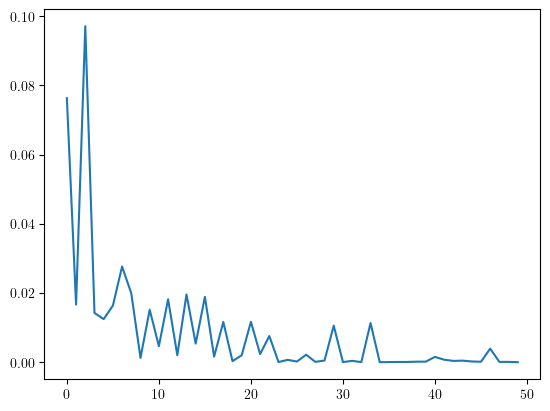

In [6]:
import time
losses = []

for e in tqdm(range(50)):
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        labels_hat_dist = model(images)
        adam.zero_grad()
        loss = criterion(labels_hat_dist, labels)
        loss.backward()
        adam.step()
    losses.append(loss.item())
    if e % 10 == 0:
        print(f"Epoch {e} loss: {loss.item()}", end="\r")

plt.plot(losses)
plt.show()

PATH = f'C:/Users/aless/Repos/Rug/P3/Xai/Distillation_experiments/models/{time.strftime("%m%d-%H%M%S")}.pth'
torch.save(model.state_dict(), PATH)


## Direction Sensitivity Estimation
This section aims to experiment with the first of the two tasks [(Papernot et al., 2016)](https://arxiv.org/abs/1511.04508): Direction Sensitivity Estimation. Given a sample $X$ we want to test a trained model $F$ on perturbated version of the sample (i.e. $\delta X$) to find the dimensions of $X$ that will produce expected adversarial behavior (misclassification) with the *smallest* perturbation. We formalize the problem as a linear program:
$$\arg\min_{\delta X}||\delta X|| \text{ s.t. } F(X+\delta X) = Y^*$$
where $Y^*$ is the adverserial class indicator vector. Following [(Goodfellow et al., 2014)](https://arxiv.org/pdf/1412.6572) we calculate the sign of the gradient (i.e. `step = images.grad.sign()`) and after defining a perturbation of $\delta = 0.2$ and calculate the loss for both vanilla and perturbated sample to study the loss.

In [7]:
images, labels = next(iter(testloader))
images = images.to(device)
labels = labels.to(device)

# Inside train loop
images.requires_grad = True
labels_hat_dist = model(images)
loss = criterion(labels_hat_dist, labels)
loss.backward()

print("Original loss", loss.item())


step = images.grad.sign()
perturbed_image = images + 0.2*step
perturbed_image = torch.clamp(perturbed_image, 0, 1)

labels_hat_dist = model(perturbed_image)
loss = criterion(labels_hat_dist, labels)
print("Adv loss", loss.item())

Original loss 0.014117736369371414
Adv loss 0.09129159152507782


GroundTruth:  7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5     9     7     3     4     9     6     6     5     4     0     7     4     0     1     3     1     3     4     7     2     7     1     2     1     1     7     4     2     3     5     1     2     4     4     6     3     5     5     6     0     4     1     9     5     7     8     9     3     7     4     6     4     3     0     7     0     2     9     1     7     3     2     9     7     7     6     2     7     8     4     7     3     6     1     3     6     9     3     1     4     1     7     6     9     6     0     5     4     9     9     2     1     9     4     8     7     3     9     7     4     4     4     9     2     5     4     7     6     7     9     0     5    
Predicted:  7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5     9     7     3     4     9     6     6     5     4     0     7     4     0     1     3     1     3     4     7 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.786341].


Averserial:  7     2     1     0     4     1     4     9     8     4     9     6     4     0     1     5     9     7     5     4     4     5     6     5     4     0     7     4     0     1     3     1     3     4     7     2     2     1     2     1     0     2     4     6     3     5     1     2     4     4     6     3     5     3     6     0     4     1     9     5     7     8     8     8     7     4     6     4     3     9     7     0     2     9     1     7     3     2     8     7     7     6     2     7     8     4     7     3     6     1     3     6     8     3     1     8     1     7     0     9     6     0     5     4     5     9     2     0     9     4     8     7     3     9     7     9     4     4     9     2     5     8     7     6     7     9     0     5    
Attack:  fail fail fail fail fail fail fail fail succ succ succ fail succ fail fail fail fail fail succ fail succ succ fail fail fail fail fail fail fail fail fail fail fail fail fail fail succ fail fail fail succ succ 

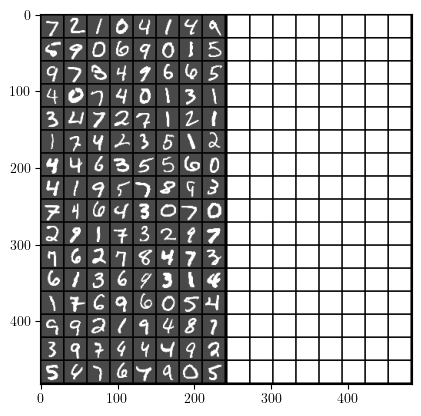

In [8]:
DELTA = 0.3

dataiter = iter(testloader)
images, labels = next(dataiter)

images = images / 2 + 0.5

limit = 0

losses = []

grid = utils.make_grid(images[:(len(labels)-limit)])
# print images

gt = [f'{classes[labels[j]]:5s}'
                              for j in range(len(labels)-(limit))]

print('GroundTruth: ', ' '.join(gt))

#net.load_state_dict(torch.load(PATH, weights_only=True))

images, labels = images.to(device), labels.to(device)

images.requires_grad = True

outputs = model(images)
loss = criterion(outputs, labels)
loss.backward()

losses.append(loss.item())

_, org_predicted = torch.max(outputs, 1)

org = [f'{classes[org_predicted[j]]:5s}'
                              for j in range(len(labels)-(limit))]

print('Predicted: ', ' '.join(org))

step = images.grad.sign()

#print(step)

perturbed_image = images + DELTA*step

perturbed_image = perturbed_image / 2 + 0.5
perturbed_image = transforms.Normalize((0.1307,), (0.3081,))(perturbed_image)


grid_n = utils.make_grid(perturbed_image[:(len(labels)-limit)])

grod = np.concatenate((np.transpose(grid, (1, 2, 0)),np.transpose(grid_n.cpu(), (1, 2, 0))), axis=1)
# print images
plt.imshow(grod)


labels_hat_dist = model(perturbed_image)
loss = criterion(labels_hat_dist, labels)

losses.append(loss.item())

_, predicted = torch.max(labels_hat_dist, 1)

adv = [f'{classes[predicted[j]]:5s}'
                              for j in range(len(labels)-(limit))]


print('Averserial: ', ' '.join(adv))

errors = 0
res = []
for o, p, a in zip(org, gt, adv):
    if o != p:
        errors += 1
        res.append('errr')
    elif o == p and o != a:
        res.append('succ')
    else:
        res.append('fail')

print(f'Attack: ', ' '.join(res))
print('\n')
print(f'Delta loss: {np.abs(losses[0]-losses[1]):.4f}\n\tOriginal loss: {losses[0]:.4f}\n\tAdversarial loss: {losses[1]:.4f}')

total=0
correct=0

for immg, labb, opred, pred in zip(perturbed_image, labels, org_predicted, predicted):
    if pred == labb and labb == opred:
        correct += 1
print(f'\nAdversary attack success rate over batch of {len(perturbed_image)} minus {errors} already misclassified samples: {(100-(100 * (correct / (len(perturbed_image)-errors)))):.2f}%\n\tDelta= {DELTA}')

In [9]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
accuracies = []
with torch.no_grad():
    for _ in tqdm(range(10)):
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            images = images/2 + 0.5
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracies.append(100 * correct / total)

print(f'Accuracy of the network on the 10000 test images: {np.mean(accuracies):.3f} %')

100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

Accuracy of the network on the 10000 test images: 99.278 %


<>:149: SyntaxWarning: invalid escape sequence '\d'
<>:156: SyntaxWarning: invalid escape sequence '\d'
<>:158: SyntaxWarning: invalid escape sequence '\%'
<>:164: SyntaxWarning: invalid escape sequence '\m'
<>:165: SyntaxWarning: invalid escape sequence '\d'
<>:168: SyntaxWarning: invalid escape sequence '\%'
<>:190: SyntaxWarning: invalid escape sequence '\d'
<>:149: SyntaxWarning: invalid escape sequence '\d'
<>:156: SyntaxWarning: invalid escape sequence '\d'
<>:158: SyntaxWarning: invalid escape sequence '\%'
<>:164: SyntaxWarning: invalid escape sequence '\m'
<>:165: SyntaxWarning: invalid escape sequence '\d'
<>:168: SyntaxWarning: invalid escape sequence '\%'
<>:190: SyntaxWarning: invalid escape sequence '\d'
C:\Users\aless\AppData\Local\Temp\ipykernel_15404\1553765105.py:149: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel('Perturbation magnitude $\delta$')
C:\Users\aless\AppData\Local\Temp\ipykernel_15404\1553765105.py:156: SyntaxWarning: invalid escape sequence 

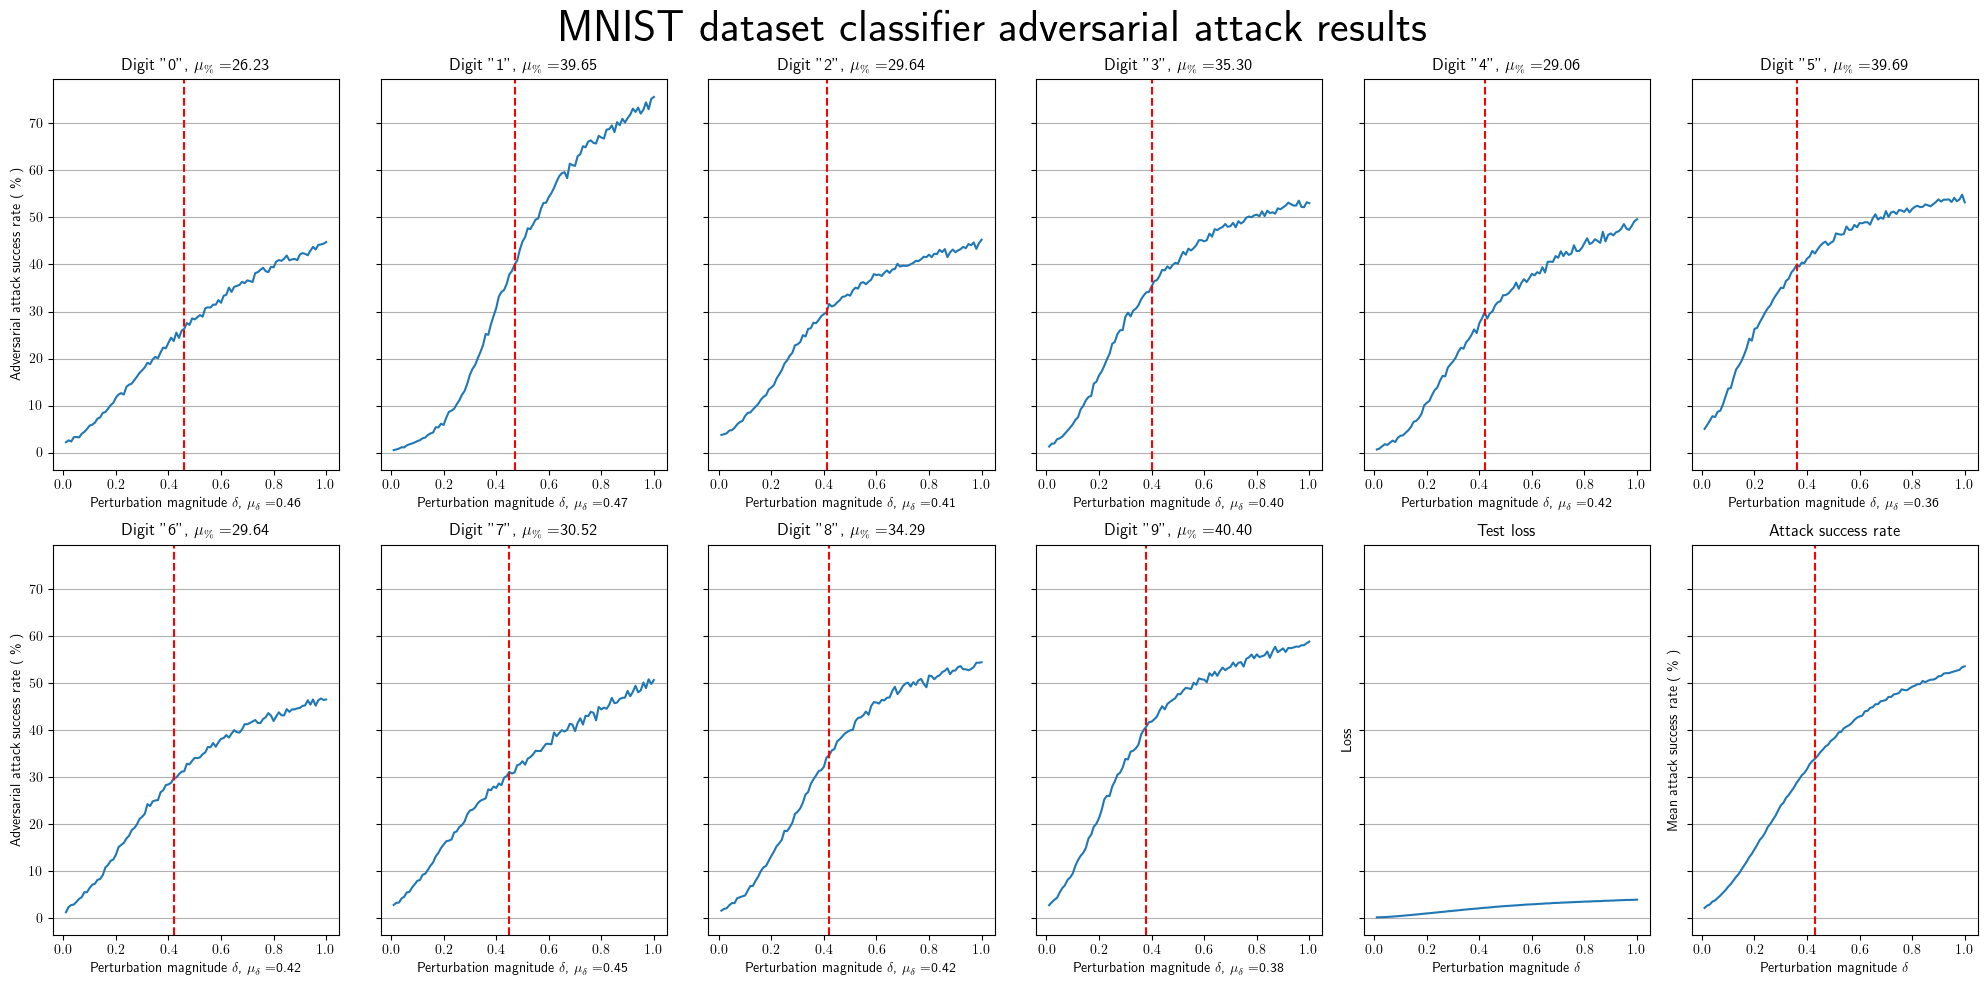

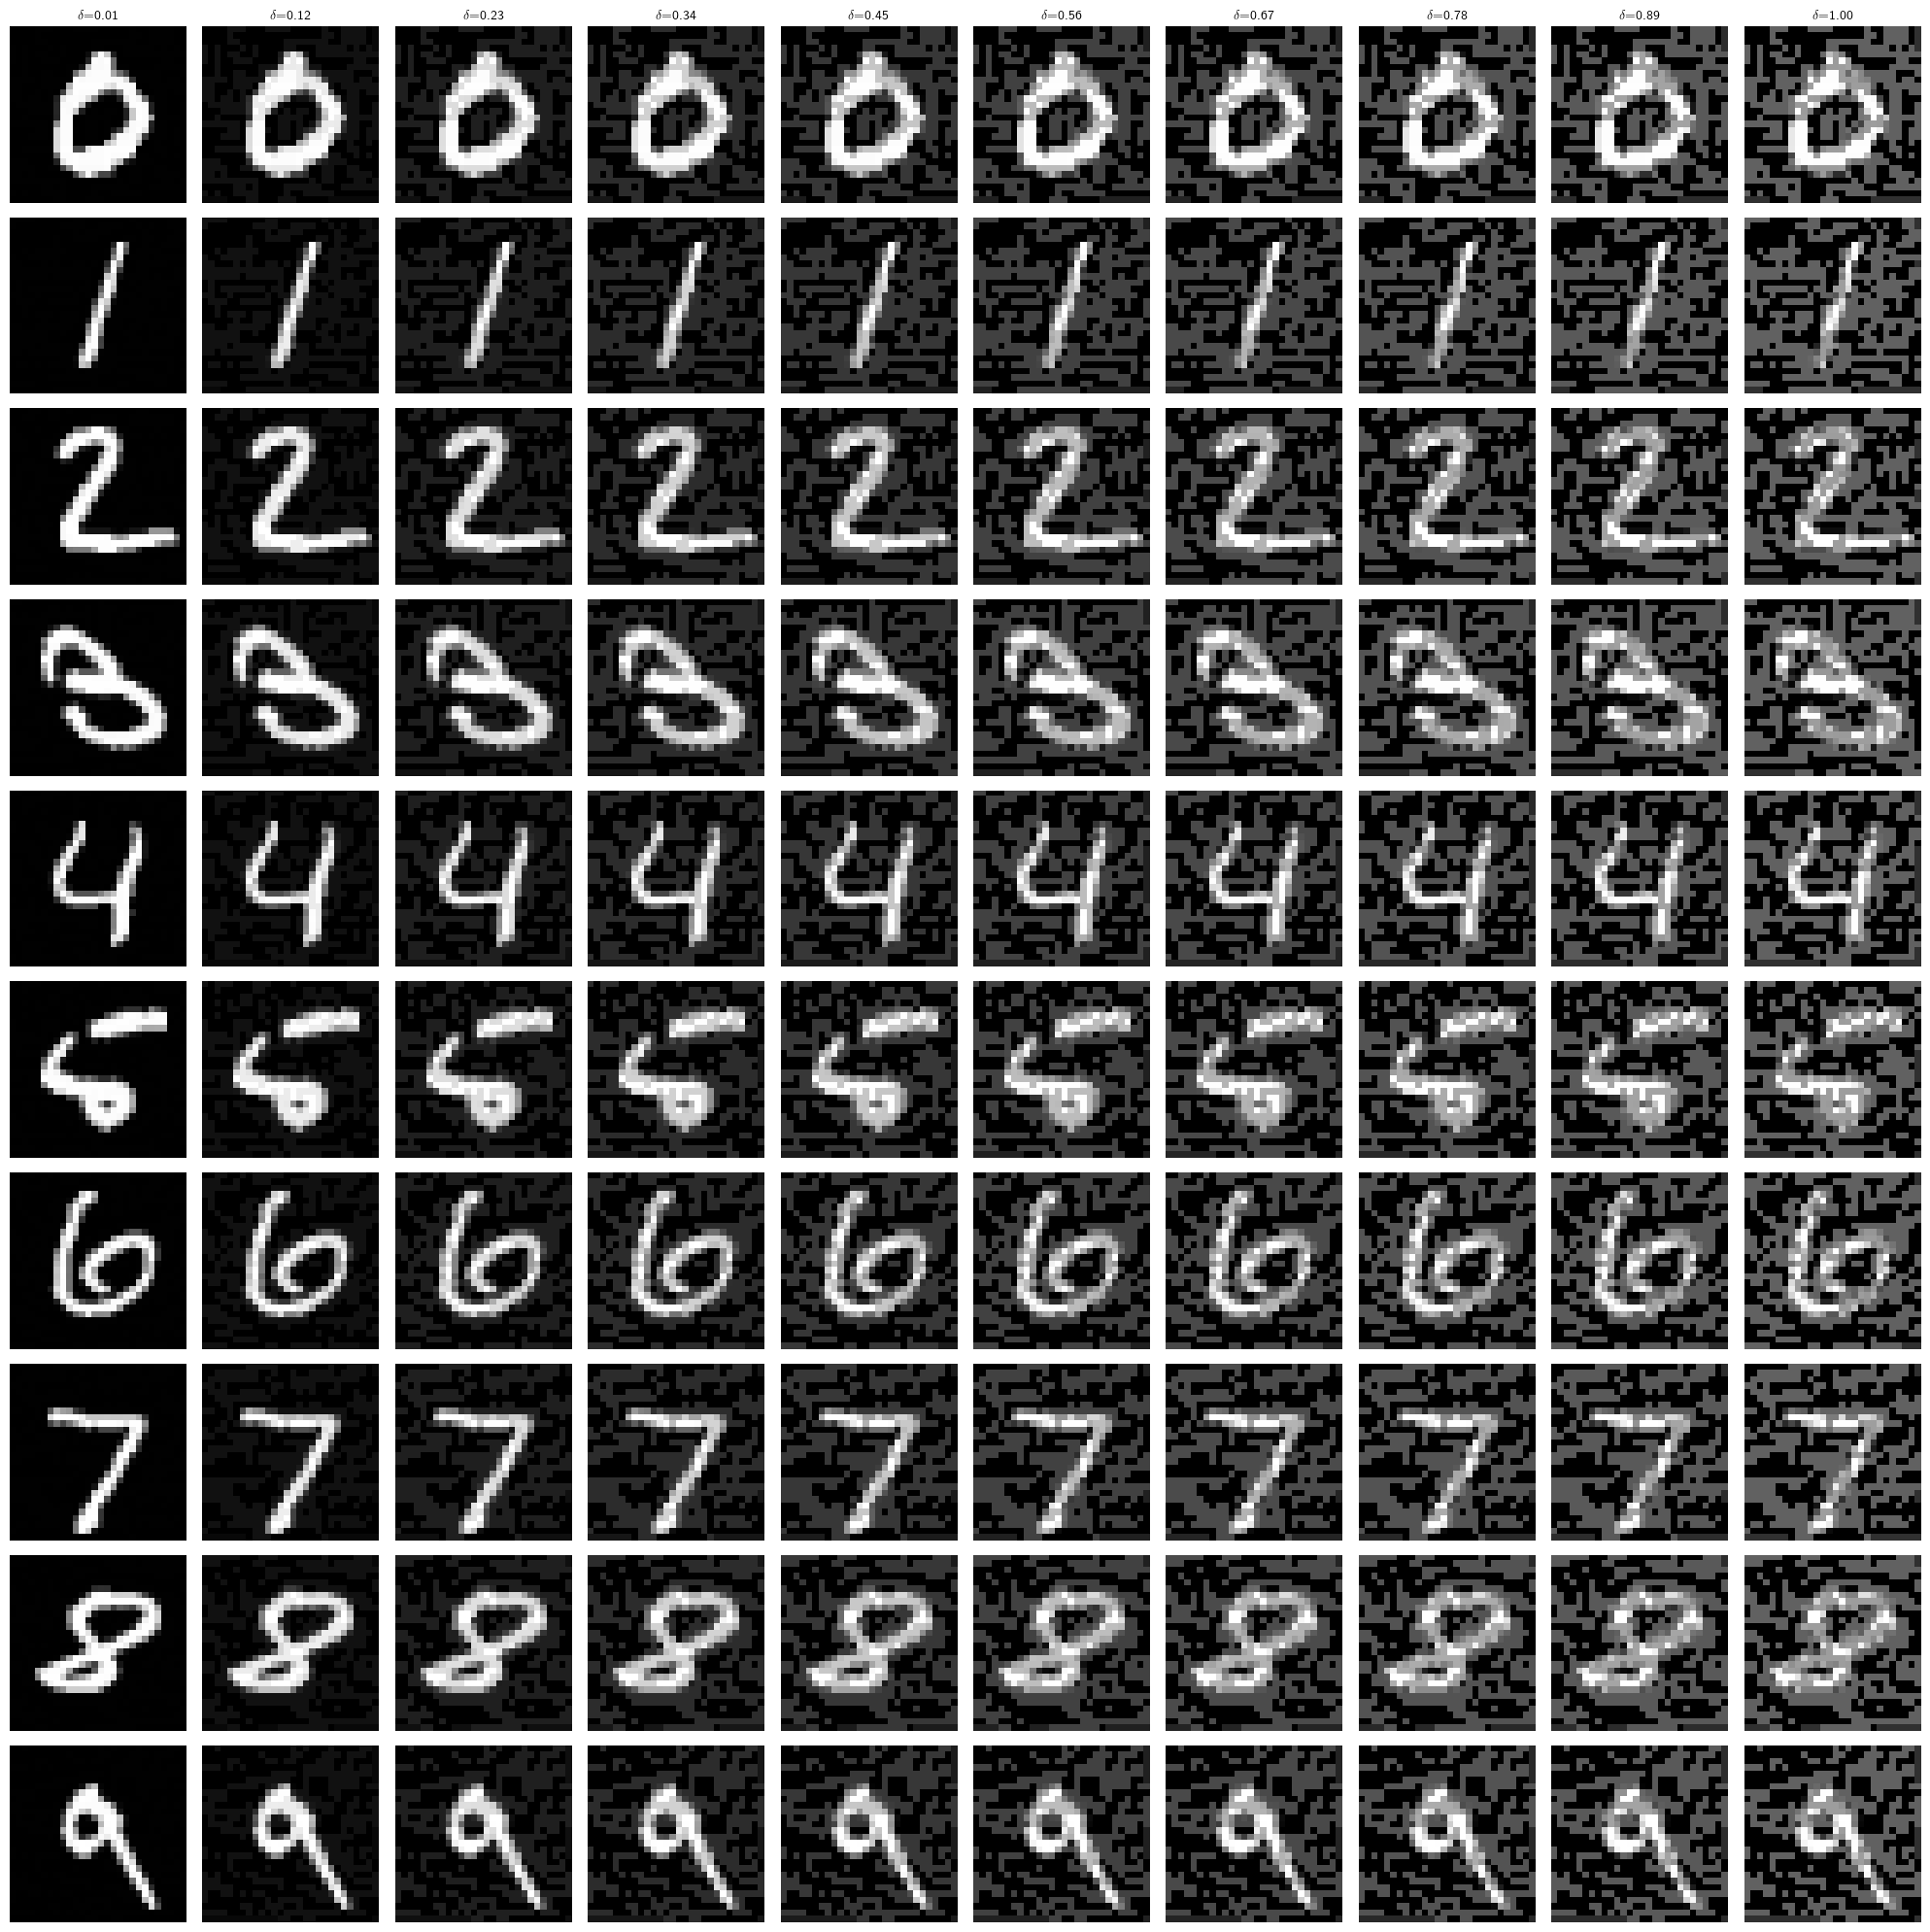

In [69]:
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Generate the delta schedule
delta_schedule = np.linspace(0.01, 1.0, 100)


# ---------------------------------------------------------------------
# STEP 1: Select representative samples from the whole test set.
# (We pick one correctly classified sample per class along with its gradient)
representative_samples = {}  # dict mapping class name to (image, grad)
for images, labels in tqdm(testloader, desc='Batch progress'):
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True

    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    
    # Iterate through the batch and select the first correct sample per class
    _, org_predicted = torch.max(outputs, 1)
    for i in range(len(labels)):
        if org_predicted[i] == labels[i]:
            cls = classes[labels[i].item()]  # assume classes is a list of class names
            if cls not in representative_samples:
                # store the image and its gradient (detach to avoid tracking)
                representative_samples[cls] = (images[i].detach(), images.grad[i].detach())
        if len(representative_samples) == len(classes):
            break
    if len(representative_samples) == len(classes):
        break

# Preselect 10 delta values (equally spaced from the delta_schedule) for visualization
delta_indices = np.linspace(0, len(delta_schedule)-1, 10, dtype=int)
selected_deltas = delta_schedule[delta_indices]

def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    return delta_schedule[idx]

# ---------------------------------------------------------------------
# STEP 2: Main adversarial evaluation loop over the whole test set.
# We compute (for each iteration) the gradients for all test samples and then for each delta
# evaluate the attack success rate (only on originally correctly classified images)
big_loss = []
big_acc = []
big_success = []

# Outer loop (repeat evaluation several times, as in your original code)
for _ in tqdm(range(2), desc='Evaluation runs'):
    # Accumulate images, labels and gradients from all test batches
    all_images_list = []
    all_labels_list = []
    all_gradients_list = []
    
    for images, labels in tqdm(testloader, desc='Batch progress'):
        images = images.to(device)
        labels = labels.to(device)
        images = images / 2 + 0.5  # Unnormalize images for visualization
        images.requires_grad = True
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()
        
        all_images_list.append(images.detach())
        all_labels_list.append(labels.detach())
        all_gradients_list.append(images.grad)
    
    # Concatenate the results to get the full test set
    all_images = torch.cat(all_images_list, dim=0)
    all_labels = torch.cat(all_labels_list, dim=0)
    all_gradients = torch.cat(all_gradients_list, dim=0)
    
    # Compute original predictions on the entire test set
    with torch.no_grad():
        outputs = model(all_images)
        org_predicted = outputs.argmax(dim=1)
    
    # Create a boolean mask for samples that were correctly classified originally
    correct_mask = (org_predicted == all_labels)
    
    losses = []
    class_accuracies = []
    success_rate = []
    
    # Evaluate the adversarial attack for each delta value in the schedule
    for delta in tqdm(delta_schedule, desc='Delta schedule'):
        # Compute the adversarial examples: note the perturbation is computed with the sign of the gradient
        perturbed = all_images + delta * all_gradients.sign()
        perturbed = perturbed / 2 + 0.5  # Unnormalize images for visualization

        perturbed = transforms.Normalize((0.1307,), (0.3081,))(perturbed)
        # perturbed = torch.clamp(perturbed, 0, 1)
        
        adv_outputs = model(perturbed)
        loss_val = criterion(adv_outputs, all_labels)
        losses.append(loss_val.item())
        
        adv_predicted = adv_outputs.argmax(dim=1)
        
        # Only consider samples that were correctly classified originally
        total_count = correct_mask.sum().item()
        if total_count > 0:
            # Count those that change prediction (i.e. attack “succeeds”)
            adv_incorrect = (adv_predicted[correct_mask] != all_labels[correct_mask]).sum().item()
            sr = 100 * adv_incorrect / total_count
        else:
            sr = 0
        success_rate.append(sr)
        
        # Compute per-class attack success (only for originally correctly classified samples)
        per_class_correct = {classname: 0 for classname in classes}
        per_class_total = {classname: 0 for classname in classes}
        
        for i in range(len(all_labels)):
            if correct_mask[i]:
                cls = classes[all_labels[i].item()]
                per_class_total[cls] += 1
                if adv_predicted[i] != all_labels[i]:
                    per_class_correct[cls] += 1
        
        accu = []
        for cls in classes:
            if per_class_total[cls] > 0:
                accu.append(100 * per_class_correct[cls] / per_class_total[cls])
            else:
                accu.append(0)
        class_accuracies.append(accu)
    
    big_loss.append(losses)
    big_acc.append(class_accuracies)
    big_success.append(success_rate)

# ---------------------------------------------------------------------
# STEP 3: Plot the adversarial evaluation curves

fig, axes = plt.subplots(2, int((len(classes)+2)/2), figsize=(20, 10), sharey=True)
for i, ax in enumerate(axes.flatten()):
    if i == len(classes):
        ax.plot(delta_schedule, np.mean(big_loss, axis=0))
        ax.set_title('Test loss')
        ax.set_xlabel('Perturbation magnitude $\delta$')
        ax.grid(True, axis='y')
        ax.set_ylabel('Loss')
    elif i == len(classes)+1:
        ax.plot(delta_schedule, np.mean(big_success, axis=0))
        ax.axvline(x=find_nearest(np.mean(big_success, axis=0),np.mean(np.mean(big_success, axis=0))), color='r', linestyle='--')
        ax.set_title('Attack success rate')
        ax.set_xlabel('Perturbation magnitude $\delta$')
        ax.grid(True, axis='y')
        ax.set_ylabel('Mean attack success rate ( \% )')
    else:
        # For each digit, extract the corresponding success rate curves over delta
        accs = [acc[i] for acc in np.mean(big_acc, axis=0)]
        ax.plot(delta_schedule, accs)
        ax.axvline(x=find_nearest(accs,np.mean(accs)), color='r', linestyle='--')
        ax.set_title(f'Digit "{classes[i]}", ' + '$\mu_{\%} = $' + f'{np.mean(accs):.2f}')
        ax.set_xlabel('Perturbation magnitude $\delta$, $\mu_{\delta} = $' + f'{(find_nearest(accs,np.mean(accs))):.2f}')
        ax.grid(True, axis='y')
        if i % ((len(classes)+2)/2) == 0:
            ax.set_ylabel('Adversarial attack success rate ( \% )')
fig.suptitle('MNIST dataset classifier adversarial attack results', fontsize=32)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# STEP 4: Create a new figure for the representative perturbed images.
# We display a grid: one row per digit and one column per selected delta value.
fig2, axes2 = plt.subplots(nrows=len(classes), ncols=len(selected_deltas), figsize=(20, 20))

# Order classes (assuming classes are numeric strings, e.g. '0', '1', ..., '9')
sorted_classes = sorted(representative_samples.keys(), key=lambda x: int(x))
for row_idx, cls in enumerate(sorted_classes):
    img, grad_img = representative_samples[cls]
    for col_idx, delta in enumerate(selected_deltas):
        # Compute the perturbed image for this representative sample
        perturbed_img = img + delta * grad_img.sign()
        ax = axes2[row_idx, col_idx]
        ax.imshow(perturbed_img.squeeze().cpu().numpy(), cmap='gray')
        ax.axis('off')
        # Optionally, add the delta value as a title in the first row
        if row_idx == 0:
            ax.set_title(f'$\delta$={delta:.2f}', fontsize=10)
    # Label the first column with the class name
    axes2[row_idx, 0].set_ylabel(f'{cls}', fontsize=12, rotation=0, labelpad=20)
plt.tight_layout()
plt.show()


10000


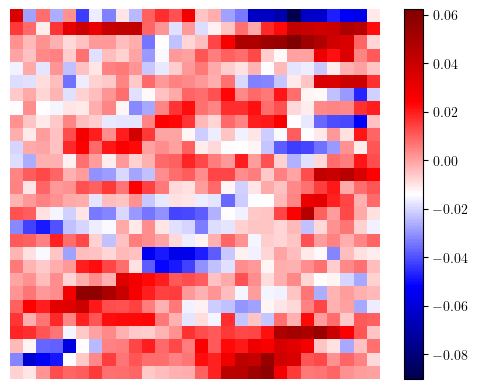

In [62]:
sign = all_gradients.sign()
sing_mean = torch.mean(sign, dim=0)
print(len(sign))
plt.imshow(sing_mean.squeeze().cpu().numpy(), cmap='seismic')
plt.axis('off')
plt.savefig('images/mean_grad.png', transparent=True)
plt.colorbar()

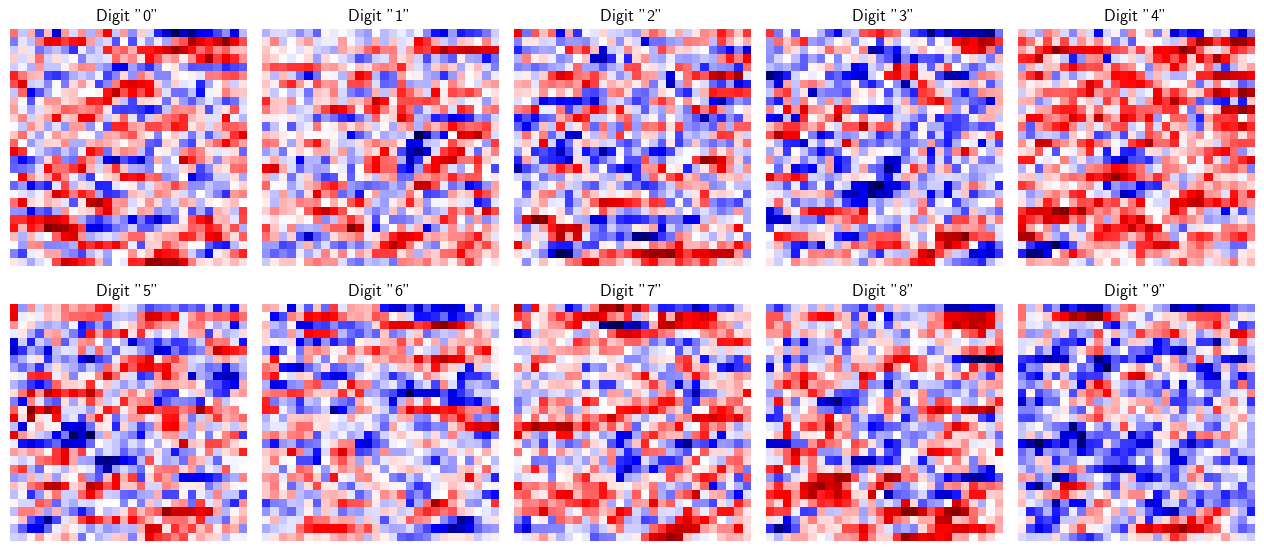

In [ ]:
num_classes = 10
cols = 5
rows = 2

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
axes = axes.flatten()  # Flatten in case of 2D array

for cls in range(num_classes):
    idx = all_labels == cls
    class_signs = sign[idx]

    if class_signs.shape[0] == 0:
        axes[cls].axis('off')
        axes[cls].set_title(f'Class {cls}\n(No Samples)')
        continue

    class_mean = torch.mean(class_signs, dim=0)  # [C, H, W]

    # Select channel (if more than one, adjust this as needed)
    img = class_mean.squeeze().cpu().numpy()

    # Show image
    im = axes[cls].imshow(img, cmap='seismic')
    axes[cls].axis('off')
    axes[cls].set_title(f'Digit "{cls}"')

# Turn off any unused subplots
for i in range(num_classes, len(axes)):
    axes[i].axis('off')



plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.savefig('images/mean_grad_per_class.png', transparent=True)
plt.show()